In [22]:
import sys
sys.path.append('../../')

**ゲート付きRNN**\
前回学んだRNNLMの手法では勾配消失と勾配爆発が起こりうる。

**勾配爆発への対策**\
勾配クリッピングと呼ばれる手法を用いることで解決

In [15]:
import numpy as np

In [2]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total = np.sqrt(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [10]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0
print('grads')
print(grads)
print('-'*100)
clip_grads(grads, max_norm)
print('grads (clip_grads)')
print(grads)


grads
[array([[2.91585734, 4.52160871, 8.90171233],
       [3.77552663, 8.32342898, 8.86643038],
       [0.62323374, 6.49377253, 7.46412909]]), array([[6.70676984, 2.52376535, 0.64094627],
       [6.23686218, 8.78568207, 9.41419369],
       [6.19644341, 7.32474617, 4.19842518]])]
----------------------------------------------------------------------------------------------------
grads (clip_grads)
[array([[0.01984237, 0.03076949, 0.06057603],
       [0.02569241, 0.05664082, 0.06033594],
       [0.0042411 , 0.04419004, 0.0507933 ]]), array([[0.04563948, 0.01717419, 0.00436163],
       [0.04244176, 0.05978645, 0.06406346],
       [0.04216671, 0.0498448 , 0.02857023]])]


**勾配消失への対策**\
勾配消失への対策はゲート付きRNNレイヤを用いる。今回はゲート付きRNNの中でLSTMを考える。\
なお、ゲートはsigmoid関数で表せる。sigmoid()関数は0.0~0.1の値を出力するので出力する割合を設定できる。つまり、ゲートを通すことでそのパラメータの重要度を設定できる。\
各時系列ごとのRNNレイヤは記憶セルcを持ち、記憶セルcから隠れ状態が計算される。\
\
まず、出力$h_t$を考える。\
$h_t$は記憶セル$c_t$から計算される。この$tanh(c_t)$の計算にoutputゲート$o$を適用する。$o$と$tanh(c_t)$の要素ごとの積(アダマール積)を出力とする。
$$h_t=o * tanh(c_t)$$
$$o=sigmoid(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$$
\
次に$c_t$の計算c()を考える。\
$$c_t=c(c_{t-1}, h_{t-1}, x_t)$$
まず、$c_{t-1}$をそのまま利用するのではなく不要な情報を忘れさせるためのforgetゲートが必要。このゲートの重み$f$は以下のようになる。
$$f=sigmoid(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$$
次に、記憶セルに新しく覚えさせるための処理を考える。「情報」の処理なので活性化関数にtanhを用いる。新しい記憶は$g$で表す。
$$g=tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$$
この$g$にinputゲート$i$を通す。
$$i=sigmoid(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$$
以上より$c_t$は以下のように表せる。
$$c_t=f * c_{t-1} + i * g$$


**LSTMの実装**\
$o$, $f$, $g$, $i$はアフィン変換を行っている。\
線形性より4つの重みを一つにまとめることができる。
$$x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)}$$
$$x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)}$$
$$x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)}$$
$$x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)}$$
\
$$x_t[W_x^{(f)}+W_x^{(g)}+W_x^{(i)}+W_x^{(o)}]+h_{t-1}[ W_h^{(f)}+W_h^{(g)}+W_h^{(i)}+W_h^{(o)} ]+[b^{(f)}+b^{(g)}+b^{(i)}+b^{(o)}]$$
\
$$x_tW_x + h_{t-1}W_h + b$$
したがってまず重み全体をアフィン変換し、そこからsliceノードによって4つに分けて取り出す。

In [14]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # Affine変換
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        # sigmoid
        f = sigmoid(f)
        g = sigmoid(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + i * g
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

**TIME LSTMレイヤの実装**

In [20]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N;batch, T;時系列データ数, D;各時系列データ(入力)次元数
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            later = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dout):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape # N;batch, T;時系列データ数, H;各時系列データ(出力)次元数
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

**LSTMを用いた言語モデル**

In [24]:
from common.time_layers import *
import pickle

In [32]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = {
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        }
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

**PTBデータセットの学習**

In [37]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

In [28]:
# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 35 #RNNの展開サイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

#学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

Done
Done


In [38]:
# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.89
| epoch 1 |  iter 21 / 1327 | time 10[s] | perplexity 3075.13
| epoch 1 |  iter 41 / 1327 | time 24[s] | perplexity 1226.72
| epoch 1 |  iter 61 / 1327 | time 37[s] | perplexity 989.04
| epoch 1 |  iter 81 / 1327 | time 50[s] | perplexity 823.01
| epoch 1 |  iter 101 / 1327 | time 63[s] | perplexity 662.78
| epoch 1 |  iter 121 / 1327 | time 77[s] | perplexity 666.56
| epoch 1 |  iter 141 / 1327 | time 92[s] | perplexity 597.56
| epoch 1 |  iter 161 / 1327 | time 105[s] | perplexity 571.22
| epoch 1 |  iter 181 / 1327 | time 118[s] | perplexity 585.68
| epoch 1 |  iter 201 / 1327 | time 132[s] | perplexity 505.34
| epoch 1 |  iter 221 / 1327 | time 145[s] | perplexity 496.20
| epoch 1 |  iter 241 / 1327 | time 158[s] | perplexity 439.43
| epoch 1 |  iter 261 / 1327 | time 172[s] | perplexity 456.37
| epoch 1 |  iter 281 / 1327 | time 185[s] | perplexity 444.46
| epoch 1 |  iter 301 / 1327 | time 198[s] | perplexity 398.18
| e

| epoch 2 |  iter 1261 / 1327 | time 1734[s] | perplexity 123.31
| epoch 2 |  iter 1281 / 1327 | time 1748[s] | perplexity 122.90
| epoch 2 |  iter 1301 / 1327 | time 1763[s] | perplexity 158.88
| epoch 2 |  iter 1321 / 1327 | time 1778[s] | perplexity 153.35
| epoch 3 |  iter 1 / 1327 | time 1783[s] | perplexity 160.90
| epoch 3 |  iter 21 / 1327 | time 1796[s] | perplexity 145.05
| epoch 3 |  iter 41 / 1327 | time 1810[s] | perplexity 135.47
| epoch 3 |  iter 61 / 1327 | time 1824[s] | perplexity 128.59
| epoch 3 |  iter 81 / 1327 | time 1838[s] | perplexity 118.61
| epoch 3 |  iter 101 / 1327 | time 1852[s] | perplexity 106.30
| epoch 3 |  iter 121 / 1327 | time 1866[s] | perplexity 116.42
| epoch 3 |  iter 141 / 1327 | time 1880[s] | perplexity 126.48
| epoch 3 |  iter 161 / 1327 | time 1894[s] | perplexity 143.25
| epoch 3 |  iter 181 / 1327 | time 1907[s] | perplexity 151.57
| epoch 3 |  iter 201 / 1327 | time 1920[s] | perplexity 141.09
| epoch 3 |  iter 221 / 1327 | time 1934[s

| epoch 4 |  iter 1161 / 1327 | time 3528[s] | perplexity 90.88
| epoch 4 |  iter 1181 / 1327 | time 3543[s] | perplexity 96.03
| epoch 4 |  iter 1201 / 1327 | time 3558[s] | perplexity 84.03
| epoch 4 |  iter 1221 / 1327 | time 3573[s] | perplexity 75.63
| epoch 4 |  iter 1241 / 1327 | time 3587[s] | perplexity 92.10
| epoch 4 |  iter 1261 / 1327 | time 3602[s] | perplexity 93.86
| epoch 4 |  iter 1281 / 1327 | time 3617[s] | perplexity 89.94
| epoch 4 |  iter 1301 / 1327 | time 3631[s] | perplexity 112.01
| epoch 4 |  iter 1321 / 1327 | time 3646[s] | perplexity 110.91


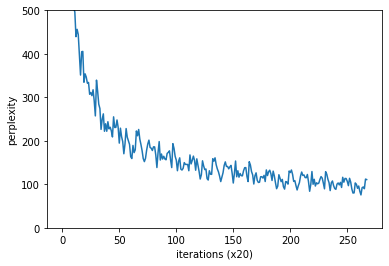

In [39]:
# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

In [41]:
# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

evaluating perplexity ...
234 / 235
test perplexity:  134.17293068722188


In [42]:
model.save_params()

最終的なパープレキシティは110程度であり、最初の10000に比べて大きく減らせている。テストデータでも130程度であり、若干の過学習が生じている。

**RNNの改善**\
3つの手法がある。
1. LSTMレイヤの多層化\
PTBデータセットの言語モデルの場合LSTMレイヤの層数は2~4程度がよい
2. Dropoutによる過学習の抑制\
多層にすることで過学習が生じる場合がある。Dropoutはランダムにニューロンを選び、そのニューロンの信号を止めることである。Dropoutレイヤは活性化関数の後に挿入する。今回は深さ方向に対してLSTMレイヤの後に挿入する。変分Dropoutを用いることで時間方向に対してDropoutを適用できる。
3. 重み共有\
EmbeddingレイヤとAffineレイヤの重みを結びつける。形状に注意して転置させることが必要。学習させる重みが少なくなるメリットもある。

**BetterRnnlmの実装**\
基本的にはRnnlmと一緒である。初期化の際のlayersの中身が上述したようになっている

In [ ]:
# 疑似コード

# ~略
self.layers = {
    TimeEmbedding(embed_W),
    TimeDropout(dropout_ratio),
    TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
    TimeDropout(dropout_ratio),
    TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
    TimeDropout(dropout_ratio),
    TimeAffine(embed_W.T, affine_b)
}
# 略~

注目するのはTimeAffine()の重みである。重み共有をするためembed_Wを渡している。形状を合わせるために転置を行うことに注意